In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

In [5]:
batches = ["E326_09321", "E326_09322", "E326_09323", "E326_09324", "E326_09326", "E326_09327"]

In [6]:
def gaussian(x, params):
    return params[0] + params[1] * np.exp(
        -0.5 * ((x - params[2]) / params[3])** 2.)

def obj_func(params, x, y):
    return np.mean((gaussian(x, params) - y)** 2.)

def get_moments(image, print_=False):
    x_axis = np.arange(image.shape[0])
    y_axis = np.arange(image.shape[1])
    
    params_x = minimize(obj_func, np.array([0., 100., 150., 20]),
                      args=(x_axis, np.mean(image, axis=1)), method="powell").x
    params_y = minimize(obj_func, np.array([0., 100., 200., 20]),
                      args=(y_axis, np.mean(image, axis=0)), method="powell").x
    x_sig = np.abs(params_x[3])
    x_mu = params_x[2]
    y_sig = np.abs(params_y[3])
    y_mu = params_y[2]
    
    if print_:
        print(x_sig, y_sig)
        fig, ax = plt.subplots()
        ax.plot(x_axis, np.mean(image, axis=1))
        ax.plot(x_axis, gaussian(x_axis, params_x))
        ax.plot(y_axis, np.mean(image, axis=0))
        ax.plot(y_axis, gaussian(y_axis, params_y))
        plt.show()
        
    if y_mu < 100:
        fig, ax = plt.subplots()
        ax.plot(x_axis, np.mean(image, axis=1))
        ax.plot(x_axis, gaussian(x_axis, params_x))
        ax.plot(y_axis, np.mean(image, axis=0))
        ax.plot(y_axis, gaussian(y_axis, params_y))
        plt.show()
        input()
    
    

    if x_sig > 100 or y_sig > 100:
        return np.array([x_mu, y_mu, x_sig, y_sig]), False
    else:
        return np.array([x_mu, y_mu, x_sig, y_sig]), True

def get_moments_batch(batch):
    print(batch.shape)
    if len(batch.shape) == 5:
        moments = np.zeros((*batch.shape[:3], 4))
        for i in range(batch.shape[0]):
            for j in range(batch.shape[1]):
                for k in range(batch.shape[2]):
                    moments[i, j, k], sucess = get_moments(batch[i, j, k])
                    if not sucess:
                        print(i, j, k)
    elif len(batch.shape) == 4:
        moments = np.zeros((*batch.shape[:2], 4))
        for i in range(batch.shape[0]):
            for j in range(batch.shape[1]):
                moments[i, j], sucess = get_moments(batch[i, j])
                if not sucess:
                    print(i, j)
    elif len(batch.shape) == 3:
        moments = np.zeros((*batch.shape[:1], 4))
        for i in range(batch.shape[0]):
            moments[i], sucess = get_moments(batch[i])
            if not sucess:
                print(i)
    else:
        raise Exception("Wrong size batch.")
    return moments

def pop_axis(data, axis):
    return np.concatenate([data[:axis], data[axis + 1:]], axis=0), data[axis]

In [7]:
## First get the backgrounds
data_path = "/media/DataDisk/E326/Jun09/"
batch = "E326_09285"

datat_struct = loadmat(data_path + batch + "/" + batch + ".mat")["data_struct"]
background_b1b2 = np.array(datat_struct[0][0][-1][0][0][4].T, dtype=np.float32)
background_b1b2 = background_b1b2[70:198, 48:176]
background_b2b3 = np.array(datat_struct[0][0][-1][0][0][5].T, dtype=np.float32)
background_b2b3 = background_b2b3[154:282, 91:219]
background_b3b4 = np.array(datat_struct[0][0][-1][0][0][6].T, dtype=np.float32)
background_b3b4 = background_b3b4[350:478, 110:238]
background_prof = np.array(datat_struct[0][0][-1][0][0][6].T, dtype=np.float32)
print(background_b1b2.shape, background_b2b3.shape, background_b3b4.shape)
print(background_prof.shape)


start_b1b2 = [488, 552]
start_b2b3 = [324, 547]
start_b3b4 = [418, 494]
start_prof = [488, 554]


moments_total = []
b1b2_total = []
b2b3_total = []
b3b4_total = []
field_total = []

shape = None
for i, batch in enumerate(batches):
    print(i, batch)
    
    # Get index for params
    datat_struct = loadmat(data_path + batch + "/" + batch + ".mat")["data_struct"]
    if len(datat_struct[0][0][1][0][0][5][0][0]) == 2:
        index_b1b2 = 1
        index_b2b3 = 2
        index_b3b4 = 3
    else:
        index_b1b2 = 2
        index_b2b3 = 3
        index_b3b4 = 4
    min_b1b2_y = datat_struct[0][0][1][0][0][index_b1b2][0][0][5][0][0]
    min_b1b2_x = datat_struct[0][0][1][0][0][index_b1b2][0][0][6][0][0]
    min_b2b3_y = datat_struct[0][0][1][0][0][index_b2b3][0][0][5][0][0]
    min_b2b3_x = datat_struct[0][0][1][0][0][index_b2b3][0][0][6][0][0]
    min_b3b4_y = datat_struct[0][0][1][0][0][index_b3b4][0][0][5][0][0]
    min_b3b4_x = datat_struct[0][0][1][0][0][index_b3b4][0][0][6][0][0]
    
    index_b1b2 = [start_b1b2[0] - min_b1b2_x, start_b1b2[1] - min_b1b2_y]    
    index_b2b3 = [start_b2b3[0] - min_b2b3_x, start_b2b3[1] - min_b2b3_y]
    index_b3b4 = [start_b3b4[0] - min_b3b4_x, start_b3b4[1] - min_b3b4_y]
    
    # Get image data
    file_path_b1b2 = data_path + batch + "/images/PR11334/PR11334_data.h5"
    file_b1b2 = h5py.File(file_path_b1b2, "r")
    file_path_b2b3 = data_path + batch + "/images/PR11342/PR11342_data.h5"
    file_b2b3 = h5py.File(file_path_b2b3, "r")
    file_path_b3b4 = data_path + batch + "/images/PR11356/PR11356_data.h5"
    file_b3b4 = h5py.File(file_path_b3b4, "r")
    
    data_b1b2 = np.array(file_b1b2['entry/data/data'].astype(np.float32))
    data_b2b3 = np.array(file_b2b3['entry/data/data'].astype(np.float32))
    data_b3b4 = np.array(file_b3b4['entry/data/data'].astype(np.float32))
    data_b1b2 = data_b1b2[..., index_b1b2[0]:index_b1b2[0]+128, index_b1b2[1]:index_b1b2[1]+128]
    data_b1b2 = np.clip((data_b1b2 - background_b1b2), 0, 300)
    data_b2b3 = data_b2b3[..., index_b2b3[0]:index_b2b3[0]+128, index_b2b3[1]:index_b2b3[1]+128]
    data_b2b3 = np.clip((data_b2b3 - background_b2b3), 0, 300)
    data_b3b4 = data_b3b4[..., index_b3b4[0]:index_b3b4[0]+128, index_b3b4[1]:index_b3b4[1]+128]
    data_b3b4 = np.clip((data_b3b4 - background_b3b4), 0, 300)
    
    b1b2_total.append(data_b1b2)
    b2b3_total.append(data_b2b3)
    b3b4_total.append(data_b3b4)
    
    # Now do the field
    field = datat_struct[0][0][0][0][0][28][0][0][0]
    field = np.tile(field, (40, 1)).T
    field_total.append(field)
    
    # Now do the beam size / moments
    file_path = data_path + batch + "/images/PR11375/PR11375_data.h5"
    file = h5py.File(file_path, "r")
    
    if len(datat_struct[0][0][1][0][0][5][0][0]) == 2:
        index_375 = 4
        if np.array(datat_struct[0][0][-1][0][0][6].T, dtype=np.float32).shape != shape:
            background_prof = np.array(datat_struct[0][0][-1][0][0][6].T, dtype=np.float32)
            shape = background_prof.shape
    else:
        index_375 = 5
        if np.array(datat_struct[0][0][-1][0][0][7].T, dtype=np.float32).shape != shape:
            background_prof = np.array(datat_struct[0][0][-1][0][0][7].T, dtype=np.float32)
            shape = background_prof.shape
    
    min_prof_x = datat_struct[0][0][1][0][0][index_375][0][0][6][0][0]    
    min_prof_y = datat_struct[0][0][1][0][0][index_375][0][0][5][0][0]
    index_prof = [start_prof[0] - min_prof_x, start_prof[1] - min_prof_y] 
    
    data_prof = np.array(file['entry/data/data'])
    data_prof = data_prof - background_prof
    data_prof = data_prof[..., index_prof[0]:index_prof[0]+200, index_prof[0]:index_prof[0]+400]

    moments = get_moments_batch(data_prof)
    moments_total.append(moments)
    
    

(128, 128) (128, 128) (128, 128)
(600, 342)
0 E326_09321
shape1  (40, 40, 294, 488) 454
(40, 40, 200, 400)
1 E326_09322
shape1  (40, 40, 294, 488) 454
(40, 40, 200, 400)
2 E326_09323
shape1  (40, 40, 294, 488) 454
(40, 40, 200, 400)
3 E326_09324
shape1  (40, 40, 294, 488) 454
(40, 40, 200, 400)
4 E326_09326
shape1  (40, 40, 294, 488) 454
(40, 40, 200, 400)
5 E326_09327
shape1  (40, 40, 294, 488) 454
(40, 40, 200, 400)


Text(0, 0.5, '$\\Sigma_{y, y} (mm^2)$')

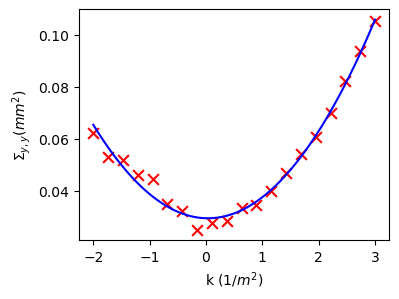

In [8]:
# Do a quick quad scan check
x_axis = np.linspace(-2, 3, 20)
fig, ax = plt.subplots(figsize=(4, 3))
beam_y = moments_total[1][4:24, 20, 3].flatten()**2.
beam_y = 400**2 * beam_y / (600 * 1000000)
ax.scatter(x_axis, beam_y, marker="x", color= "red", s=60)
params = np.polyfit(x_axis, beam_y , 2)
x_axis2 = np.linspace(-2, 3, 200)

ax.plot(x_axis2, params[0] * x_axis2**2 + params[1] * x_axis2 + params[2], color="blue")
ax.set_xlabel("k (1/$m^2$)")
ax.set_ylabel("$\Sigma_{y, y} (mm^2)$")

In [9]:
# Get the test
index = 2
b1b2_test = b1b2_total.pop(index)
b2b3_test = b2b3_total.pop(index)
b3b4_test = b3b4_total.pop(index)
moments_test = moments_total.pop(index)
field_test = field_total.pop(index)

b1b2_train = b1b2_total
b2b3_train = b2b3_total
b3b4_train = b3b4_total
moments_train = moments_total
field_train = field_total

miss_step = [8, 9, 10, 11, 12]

b1b2_val = []
b2b3_val = []
b3b4_val = []
moments_val = []
field_val = []
for i, step in enumerate(miss_step):
    b1b2_train[i], val = pop_axis(b1b2_train[i], step)
    b1b2_val.append(val)
    b2b3_train[i], val = pop_axis(b2b3_train[i], step)
    b2b3_val.append(val)
    b3b4_train[i], val = pop_axis(b3b4_train[i], step)
    b3b4_val.append(val)
    moments_train[i], val = pop_axis(moments_train[i], step)
    moments_val.append(val)
    field_train[i], val = pop_axis(field_train[i], step)
    field_val.append(val)

In [10]:
# Change train to np array
b1b2_train = np.stack(b1b2_train)
b2b3_train = np.stack(b2b3_train)
b3b4_train = np.stack(b3b4_train)
moments_train = np.stack(moments_train)
field_train = np.stack(field_train)

# change test to np array
b1b2_test = np.stack(b1b2_test)[None]
b2b3_test = np.stack(b2b3_test)[None]
b3b4_test = np.stack(b3b4_test)[None]
moments_test = np.stack(moments_test)[None]
field_test = np.stack(field_test)[None]

# change val to np array
b1b2_val = np.stack(b1b2_val)
b2b3_val = np.stack(b2b3_val)
b3b4_val = np.stack(b3b4_val)
moments_val = np.stack(moments_val)
field_val = np.stack(field_val)

In [11]:
with h5py.File('Train.h5', 'w') as hf:
    hf.create_dataset("/B1B2",  data=b1b2_train)
    hf.create_dataset("/B2B3",  data=b2b3_train)
    hf.create_dataset("/B3B4",  data=b3b4_train)
    hf.create_dataset("/Moments", data=moments_train)
    hf.create_dataset("/Field",  data=field_train)
    
with h5py.File('Test.h5', 'w') as hf:
    hf.create_dataset("/B1B2",  data=b1b2_test)
    hf.create_dataset("/B2B3",  data=b2b3_test)
    hf.create_dataset("/B3B4",  data=b3b4_test)
    hf.create_dataset("/Moments", data=moments_test)
    hf.create_dataset("/Field",  data=field_test)
    
    hf.create_dataset("/Sample/B1B2",  data=b1b2_val)
    hf.create_dataset("/Sample/B2B3",  data=b2b3_val)
    hf.create_dataset("/Sample/B3B4",  data=b3b4_val)
    hf.create_dataset("/Sample/Moments", data=moments_val)
    hf.create_dataset("/Sample/Field",  data=field_val)
     